In [1]:
import numpy as np
from numpy import sin, cos, tan, atan, cosh, sinh, tanh, abs, linspace, argmin, argmax, pi, mean, exp, sqrt, zeros, ones, nan
import scipy
import matplotlib.pyplot as plt
from scipy.special import roots_legendre, eval_legendre
from numpy.polynomial import chebyshev

In [2]:

class rk4_sol: ...

def rk4_ivp(fun, t_span, y0, h, args=()):
    """
    Fixed-step RK4 ODE solver (no adaptivity).
    
    Parameters
    ----------
    fun : callable
        Function f(t, y, *args) returning derivatives.
    t_span : (t0, tf)
        Time interval.
    y0 : array_like
        Initial state.
    h : float
        Fixed time step.
    args : tuple
        Extra arguments passed to fun.

    Returns
    -------
    t : ndarray
        Time points.
    y : ndarray
        Solution array with shape (n_points, n_states).
    """

    t0, tf = t_span
    y0 = np.array(y0, dtype=float)

    # number of steps
    N = int(np.ceil((tf - t0)/h))

    # time grid (force exact end-point)
    t = t0 + np.arange(N + 1)*h
    
    t[-1] = tf

    y = np.zeros((N + 1, len(y0)))
    y[0] = y0

    def step(f, t, y, h):
        k1 = f(t, y, *args)
        k2 = f(t + h/2, y + h*k1/2, *args)
        k3 = f(t + h/2, y + h*k2/2, *args)
        k4 = f(t + h,   y + h*k3,   *args)
        return y + (h/6)*(k1 + 2*k2 + 2*k3 + k4)

    # integrate
    for i in range(N):
        h_step = min(h, tf - t[i])  # shrink final step if needed
        y[i+1] = step(fun, t[i], y[i], h_step)

    sol = rk4_sol
    sol.t = t 
    sol.y = y

    return sol

def rk4_step(f, t, y, h):
    k1 = f(t, y)
    k2 = f(t + h/2, y + h*k1/2)
    k3 = f(t + h/2, y + h*k2/2)
    k4 = f(t + h,   y + h*k3)
    return y + (h/6)*(k1 + 2*k2 + 2*k3 + k4)



In [3]:
class PerturbationCSWESolution(): pass

class PCSWE():

    def __init__(self):
        self.debug = False


        # geometry
        self.A = 0.72
        self.H = 7.12 
        self.L = 8e3

        # tunable
        self.r = 0.24
        self.h0 = 0.0025
        self.small_number = nan
        self.bc = nan
        # self.bc = self.bc_moving_boundary


        # morphodynamics
        self.p = 0.4 # porosity
        self.c_d = 0.0025
        self.lmbda = 6.8e-6
        self.d50 = 0.13e-3

        # universal constants
        self.g = 9.81
        self.sigma = 1.4e-4
        self.rho_w = 1025
        self.rho_s = 2650

        self.set_derivative_vars()
        
    def set_derivative_vars(self):
        self.epsilon = self.A / self.H
        self.eta = self.sigma * self.L / sqrt(self.g * self.H)
        self.U = self.epsilon * self.sigma * self.L
        self.kappa = self.g * self.H / (self.sigma * self.L) ** 2

        self.s = self.rho_s / self.rho_w

        self.delta = 0.04 * self.c_d**(3/2) * self.A * (self.sigma * self.L)**4 / \
                    (self.g**2 * (self.s-1)**2 * self.d50 * self.H**6 * (1-self.p))

    def generate_solution(self):
        # assume we have ran self.solve()
        t = linspace(0, 2*pi, 1000)
        x = self.y.x

        # x_mesh = x[:, np.newaxis] * ones(t.shape)[np.newaxis, :]
        # t_mesh = np.tile(t, (len(x), 1))


        dz0_xt = self.y.y[0][:, np.newaxis] * cos(t)[np.newaxis, :] + \
            self.y.y[1][:, np.newaxis] * sin(t)[np.newaxis, :]

        dz1_xt = self.y.y[4][:, np.newaxis] * ones(t.shape)[np.newaxis, :] + \
            self.y.y[5][:, np.newaxis] * cos(2*t)[np.newaxis, :] + \
            self.y.y[6][:, np.newaxis] * sin(2*t)[np.newaxis, :]


        u0_xt = self.y.y[2][:, np.newaxis] * cos(t)[np.newaxis, :] + \
            self.y.y[3][:, np.newaxis] * sin(t)[np.newaxis, :]

        u1_xt = self.y.y[7][:, np.newaxis] * ones(t.shape)[np.newaxis, :] + \
            self.y.y[8][:, np.newaxis] * cos(2*t)[np.newaxis, :] + \
            self.y.y[9][:, np.newaxis] * sin(2*t)[np.newaxis, :]
        
       
        dz_xt = dz0_xt + self.epsilon * dz1_xt
        u_xt = u0_xt + self.epsilon * u1_xt

        sol = PerturbationCSWESolution
        sol.x, sol.t, sol.dz_xt, sol.u_xt = x, t, dz_xt, u_xt
        return sol
    
    def h_fx(self, x): return x
    def h_fx_dx(self, x): return 1 * np.ones(np.array(x).shape)
    def h_fx_dxx(self, x): return 0
    def h_fx_dxxx(self, x): return 0
    
    def deriv_LO(self, x_x, y0_x):
        # x_x, y0_x = np.array(x_x), np.array(y0_x)
        dz0c_x, dz0s_x, u0c_x, u0s_x = y0_x
        h_x, h_x_dx, h_x_dxx = self.h_fx(x_x), self.h_fx_dx(x_x), self.h_fx_dxx(x_x)

        # derivatives of dzeta (using momentum equation)
        dz0c_x_dx = 1 / self.kappa * ( - self.r / (1 - h_x + self.h0) * u0c_x - u0s_x)
        dz0s_x_dx = 1 / self.kappa * ( - self.r / (1 - h_x + self.h0) * u0s_x + u0c_x)

        


        if abs(x_x - 1) < 1e-13:
            print("LO hop", x_x)
            u0c_x_dx =  ( dz0s_x_dx - u0c_x * h_x_dxx)  / (2*h_x_dx)
            u0s_x_dx =  (-dz0c_x_dx - u0s_x * h_x_dxx)  / (2*h_x_dx)
        else:
            u0c_x_dx = (-dz0s_x + u0c_x * h_x_dx)  / (1 - h_x)
            u0s_x_dx = ( dz0c_x + u0s_x * h_x_dx)  / (1 - h_x)

   
        return np.array([dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx])
    
    def deriv_FO(self, x_x, y1_x, y0_x, y0_x_dx):
        dz0c_x, dz0s_x, u0c_x, u0s_x = y0_x
        dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx = y0_x_dx
        dz1r_x, dz1c_x, dz1s_x, u1r_x, u1c_x, u1s_x = y1_x
        h_x, h_x_dx, h_x_dxx= self.h_fx(x_x), self.h_fx_dx(x_x), self.h_fx_dxx(x_x)

        # derivatives of dzeta (using momentum equation)
        dz1r_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1r_x - 0.5 * (  dz0c_x *  u0s_x - dz0s_x *  u0c_x)
            - 0.5 * (  dz0s_x * dz0s_x_dx + dz0c_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0c_x_dx + u0s_x * u0s_x_dx)            ) / self.kappa
        dz1c_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1c_x - 0.5 * (  dz0c_x *  u0s_x + dz0s_x *  u0c_x)
            - 0.5 * (- dz0s_x * dz0s_x_dx + dz0c_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0c_x_dx - u0s_x * u0s_x_dx) - 2 * u1s_x) / self.kappa
        dz1s_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1s_x + 0.5 * (  dz0c_x *  u0c_x - dz0s_x *  u0s_x)
            - 0.5 * (  dz0c_x * dz0s_x_dx + dz0s_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0s_x_dx + u0s_x * u0c_x_dx) + 2 * u1c_x) / self.kappa


        # derivatives of u (using continuity equation)
        
        # derivatives of first order u at x = 1 (using l'hopital)
        if abs(x_x - 1) < 1e-13:
            print("FO hop", x_x)
            u1r_x_dx, u1c_x_dx, u1s_x_dx = self.lhopital_FO(x_x, y1_x, y0_x, y0_x_dx, (dz1r_x_dx, dz1c_x_dx, dz1s_x_dx))
        else:
            u1r_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1r_x              - 1 / 2 * (dz0c_x * u0c_x_dx + dz0c_x_dx * u0c_x + dz0s_x * u0s_x_dx + dz0s_x_dx * u0s_x))
            u1c_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1c_x - 2 * dz1s_x - 1 / 2 * (dz0c_x * u0c_x_dx + dz0c_x_dx * u0c_x - dz0s_x * u0s_x_dx - dz0s_x_dx * u0s_x))
            u1s_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1s_x + 2 * dz1c_x - 1 / 2 * (dz0s_x * u0c_x_dx + dz0s_x_dx * u0c_x + dz0c_x * u0s_x_dx + dz0c_x_dx * u0s_x))

        # self.product_dxx(x_x, y0_x, y0_x_dx)

        return np.array([dz1r_x_dx, dz1c_x_dx, dz1s_x_dx, u1r_x_dx, u1c_x_dx, u1s_x_dx]) 
   
    def lhopital_FO(self, x_r, y1_r, y0_r, y0_r_dx, dz1_r_dx):
        dz0c_r, dz0s_r, u0c_r, u0s_r = y0_r
        dz0c_r_dx, dz0s_r_dx, u0c_r_dx, u0s_r_dx = y0_r_dx
        dz1r_r, dz1c_r, dz1s_r, u1r_r, u1c_r, u1s_r = y1_r
        dz1r_r_dx, dz1c_r_dx, dz1s_r_dx = dz1_r_dx
        h_r, h_r_dx, h_r_dxx, h_r_dxxx = self.h_fx(x_r), self.h_fx_dx(x_r), self.h_fx_dxx(x_r), self.h_fx_dxxx(x_r)

        # second derivatives of leading order components:
        dz0c_r_dxx = 1 / self.kappa * (- self.r / (1 - h_r + self.h0)**2 * h_r_dx * u0c_r - self.r / (1 - h_r + self.h0) * u0c_r_dx - u0s_r_dx)
        dz0s_r_dxx = 1 / self.kappa * (- self.r / (1 - h_r + self.h0)**2 * h_r_dx * u0s_r - self.r / (1 - h_r + self.h0) * u0s_r_dx + u0c_r_dx)
        u0c_r_dxx = 1/3 * (- h_r_dxx / h_r_dx**2 * ( dz0s_r_dx - u0c_r * h_r_dxx) + 1 / h_r_dx * ( dz0s_r_dxx - u0c_r_dx * h_r_dxx - u0c_r * h_r_dxxx))
        u0s_r_dxx = 1/3 * (- h_r_dxx / h_r_dx**2 * (-dz0c_r_dx - u0s_r * h_r_dxx) + 1 / h_r_dx * (-dz0c_r_dxx - u0s_r_dx * h_r_dxx - u0s_r * h_r_dxxx))

        # second derivatives of products of leading order components:
        dz_u_cc_r_dxx = (dz0c_r * u0c_r_dxx + 2 * dz0c_r_dx * u0c_r_dx + dz0c_r_dxx * u0c_r)
        dz_u_ss_r_dxx = (dz0s_r * u0s_r_dxx + 2 * dz0s_r_dx * u0s_r_dx + dz0s_r_dxx * u0s_r)
        dz_u_cs_r_dxx = (dz0s_r * u0c_r_dxx + 2 * dz0s_r_dx * u0c_r_dx + dz0s_r_dxx * u0c_r)
        dz_u_sc_r_dxx = (dz0c_r * u0s_r_dxx + 2 * dz0c_r_dx * u0s_r_dx + dz0c_r_dxx * u0s_r)

        # l'hopital
        u1r_r_dx = (             - u1r_r * h_r_dxx + (dz_u_cc_r_dxx + dz_u_ss_r_dxx) / 2) / (2*h_r_dx)
        u1c_r_dx = ( 2*dz1s_r_dx - u1c_r * h_r_dxx + (dz_u_cc_r_dxx - dz_u_ss_r_dxx) / 2) / (2*h_r_dx)
        u1s_r_dx = (-2*dz1c_r_dx - u1s_r * h_r_dxx + (dz_u_cs_r_dxx + dz_u_sc_r_dxx) / 2) / (2*h_r_dx)

        return np.array([u1r_r_dx, u1c_r_dx, u1s_r_dx])
       
    def deriv(self, x_x, y_x):
        # print(x_x)
        y0_x, y1_x = np.split(y_x, [4], axis=0)

        y0_x_dx = self.deriv_LO(x_x, y0_x)
        y1_x_dx = self.deriv_FO(x_x, y1_x, y0_x, y0_x_dx)

        y_x_dx = np.concatenate((y0_x_dx, y1_x_dx), axis=0)

        return y_x_dx

    def ivp(self, dz_r, dense_output=False):
        dz0c_r, dz0s_r, dz1r_r, dz1c_r, dz1s_r = dz_r

        
        h_r, h_r_dx, h_r_dxx = self.h_fx(1), self.h_fx_dx(1), self.h_fx_dxx(1)
        u0c_r = dz0s_r / h_r_dx
        u0s_r = -dz0c_r / h_r_dx

        dz0c_r_dx = 1 / self.kappa * ( - self.r / (1 - h_r + self.h0) * u0c_r - u0s_r)
        dz0s_r_dx = 1 / self.kappa * ( - self.r / (1 - h_r + self.h0) * u0s_r + u0c_r)
        u0c_r_dx =  ( dz0s_r_dx - u0c_r * h_r_dxx)  / (2*h_r_dx)
        u0s_r_dx =  (-dz0c_r_dx - u0s_r * h_r_dxx)  / (2*h_r_dx)

        u1r_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r + dz0s_r * u0s_r_dx + dz0s_r_dx * u0s_r))
        u1c_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r - dz0s_r * u0s_r_dx - dz0s_r_dx * u0s_r) + 2 * dz1s_r)
        u1s_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0s_r_dx + dz0c_r_dx * u0s_r + dz0s_r * u0c_r_dx + dz0s_r_dx * u0c_r) - 2 * dz1c_r)

        y_r = dz0c_r, dz0s_r, u0c_r, u0s_r, dz1r_r, dz1c_r, dz1s_r, u1r_r, u1c_r, u1s_r


        x_range = [1, 0]
        sol = scipy.integrate.solve_ivp(
            self.deriv,
            x_range,
            y_r,
            # rtol=1e-8, atol=1e-8,   # essentially forces strong accuracy
            # max_step=1e-6,
            method='DOP853',
            dense_output=dense_output
        )
        
        return sol

    def ivp_rk4(self, dz_r, dense_output=False):
        dz0c_r, dz0s_r, dz1r_r, dz1c_r, dz1s_r = dz_r

        
        h_r, h_r_dx, h_r_dxx = self.h_fx(1), self.h_fx_dx(1), self.h_fx_dxx(1)
        u0c_r = dz0s_r / h_r_dx
        u0s_r = -dz0c_r / h_r_dx

        dz0c_r_dx = 1 / self.kappa * ( - self.r / (1 - h_r + self.h0) * u0c_r - u0s_r)
        dz0s_r_dx = 1 / self.kappa * ( - self.r / (1 - h_r + self.h0) * u0s_r + u0c_r)
        u0c_r_dx =  ( dz0s_r_dx - u0c_r * h_r_dxx)  / (2*h_r_dx)
        u0s_r_dx =  (-dz0c_r_dx - u0s_r * h_r_dxx)  / (2*h_r_dx)

        u1r_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r + dz0s_r * u0s_r_dx + dz0s_r_dx * u0s_r))
        u1c_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r - dz0s_r * u0s_r_dx - dz0s_r_dx * u0s_r) - 2 * dz1s_r)
        u1s_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0s_r_dx + dz0c_r_dx * u0s_r + dz0s_r * u0c_r_dx + dz0s_r_dx * u0c_r) + 2 * dz1c_r)

        y_r = dz0c_r, dz0s_r, u0c_r, u0s_r, dz1r_r, dz1c_r, dz1s_r, u1r_r, u1c_r, u1s_r


        x_range = [1, 0]
        sol = rk4_ivp(
            self.deriv,
            x_range,
            y_r,
            -1e-4
        )
        
        return sol


    def solve_shooting(self):
        
        def mismatch(u_r):
            sol = self.ivp_own_initial_step(u_r)

            dz0c_l, dz0s_l, u0c_l, u0s_l, dz1r_l, dz1c_l, dz1s_l, u1r_l, u1c_l, u1s_l = sol.y[:, -1]
            return [dz0c_l - 1, dz0s_l, dz1r_l, dz1c_l, dz1s_l]


        dz_guess = 0.001 * np.ones((5))
        res = scipy.optimize.root(mismatch, dz_guess)
        print(res)
        if res.status == 1:
            sol = self.ivp_own_initial_step(res.x, dense_output=True)
            return res, sol
    
    def ivp_own_initial_step(self, dz_r, dense_output=False):

        dz0c_r, dz0s_r, dz1r_r, dz1c_r, dz1s_r = dz_r

        h_r, h_r_dx, h_r_dxx, h_r_dxxx = self.h_fx(1), self.h_fx_dx(1), self.h_fx_dxx(1), self.h_fx_dxxx(1)
        u0c_r = dz0s_r / h_r_dx
        u0s_r = -dz0c_r / h_r_dx

        dz0c_r_dx = 1 / self.kappa * ( - self.r / (1 - h_r + self.h0) * u0c_r - u0s_r)
        dz0s_r_dx = 1 / self.kappa * ( - self.r / (1 - h_r + self.h0) * u0s_r + u0c_r)
        u0c_r_dx =  ( dz0s_r_dx - u0c_r * h_r_dxx)  / (2*h_r_dx)
        u0s_r_dx =  (-dz0c_r_dx - u0s_r * h_r_dxx)  / (2*h_r_dx)

        u1r_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r + dz0s_r * u0s_r_dx + dz0s_r_dx * u0s_r))
        u1c_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r - dz0s_r * u0s_r_dx - dz0s_r_dx * u0s_r) - 2 * dz1s_r)
        u1s_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0s_r_dx + dz0c_r_dx * u0s_r + dz0s_r * u0c_r_dx + dz0s_r_dx * u0c_r) + 2 * dz1c_r)

        y_r = dz0c_r, dz0s_r, u0c_r, u0s_r, dz1r_r, dz1c_r, dz1s_r, u1r_r, u1c_r, u1s_r

        dz1r_r_dx = (1 / (1 - h_r + self.h0) * (- self.r * u1r_r - 0.5 * (  dz0c_r *  u0s_r - dz0s_r *  u0c_r)
            - 0.5 * (  dz0s_r * dz0s_r_dx + dz0c_r * dz0c_r_dx) * self.kappa) - 0.5 * (u0c_r * u0c_r_dx + u0s_r * u0s_r_dx)            ) / self.kappa
        dz1c_r_dx = (1 / (1 - h_r + self.h0) * (- self.r * u1c_r - 0.5 * (  dz0c_r *  u0s_r + dz0s_r *  u0c_r)
            - 0.5 * (- dz0s_r * dz0s_r_dx + dz0c_r * dz0c_r_dx) * self.kappa) - 0.5 * (u0c_r * u0c_r_dx - u0s_r * u0s_r_dx) - 2 * u1s_r) / self.kappa
        dz1s_r_dx = (1 / (1 - h_r + self.h0) * (- self.r * u1s_r + 0.5 * (  dz0c_r *  u0c_r - dz0s_r *  u0s_r)
            - 0.5 * (  dz0c_r * dz0s_r_dx + dz0s_r * dz0c_r_dx) * self.kappa) - 0.5 * (u0c_r * u0s_r_dx + u0s_r * u0c_r_dx) + 2 * u1c_r) / self.kappa

        # second derivatives of leading order components:
        dz0c_r_dxx = 1 / self.kappa * (- self.r / (1 - h_r + self.h0)**2 * h_r_dx * u0c_r - self.r / (1 - h_r + self.h0) * u0c_r_dx - u0s_r_dx)
        dz0s_r_dxx = 1 / self.kappa * (- self.r / (1 - h_r + self.h0)**2 * h_r_dx * u0s_r - self.r / (1 - h_r + self.h0) * u0s_r_dx + u0c_r_dx)
        u0c_r_dxx = 1 / 3 * (- h_r_dxx / h_r_dx**2 * ( dz0s_r_dx - u0c_r * h_r_dxx) + 1 / h_r_dx * ( dz0s_r_dxx - u0c_r_dx * h_r_dxx - u0c_r * h_r_dxxx))
        u0s_r_dxx = 1 / 3 * (- h_r_dxx / h_r_dx**2 * (-dz0c_r_dx - u0s_r * h_r_dxx) + 1 / h_r_dx * (-dz0c_r_dxx - u0s_r_dx * h_r_dxx - u0s_r * h_r_dxxx))

        # second derivatives of products of leading order components:
        dz_u_cc_r_dxx = (dz0c_r * u0c_r_dxx + 2 * dz0c_r_dx * u0c_r_dx + dz0c_r_dxx * u0c_r)
        dz_u_ss_r_dxx = (dz0s_r * u0s_r_dxx + 2 * dz0s_r_dx * u0s_r_dx + dz0s_r_dxx * u0s_r)
        dz_u_cs_r_dxx = (dz0s_r * u0c_r_dxx + 2 * dz0s_r_dx * u0c_r_dx + dz0s_r_dxx * u0c_r)
        dz_u_sc_r_dxx = (dz0c_r * u0s_r_dxx + 2 * dz0c_r_dx * u0s_r_dx + dz0c_r_dxx * u0s_r)

        # l'hopital
        u1r_r_dx = (             - u1r_r * h_r_dxx + (dz_u_cc_r_dxx + dz_u_ss_r_dxx) / 2) / (2*h_r_dx)
        u1c_r_dx = ( 2*dz1s_r_dx - u1c_r * h_r_dxx + (dz_u_cc_r_dxx - dz_u_ss_r_dxx) / 2) / (2*h_r_dx)
        u1s_r_dx = (-2*dz1c_r_dx - u1s_r * h_r_dxx + (dz_u_cs_r_dxx + dz_u_sc_r_dxx) / 2) / (2*h_r_dx)

        step = 1e-4

        dz0c_r1 = dz0c_r + step * dz0c_r_dx + step**2 / 2 * dz0c_r_dxx
        dz0s_r1 = dz0s_r + step * dz0s_r_dx + step**2 / 2 * dz0s_r_dxx
        u0c_r1 = u0c_r + step * u0c_r_dx + step**2 / 2 * u0c_r_dxx
        u0s_r1 = u0s_r + step * u0s_r_dx + step**2 / 2 * u0s_r_dxx
        dz1r_r1 = dz1r_r + step * dz1r_r_dx
        dz1c_r1 = dz1c_r + step * dz1c_r_dx
        dz1s_r1 = dz1s_r + step * dz1s_r_dx
        u1r_r1 = u1r_r + step * u1r_r_dx
        u1c_r1 = u1c_r + step * u1c_r_dx
        u1s_r1 = u1s_r + step * u1s_r_dx

        y0 = np.array([dz0c_r, dz0s_r, u0c_r, u0s_r, dz1r_r, dz1c_r, dz1s_r, u1r_r, u1c_r, u1s_r])
        y1 = np.array([dz0c_r1, dz0s_r1, u0c_r1, u0s_r1, dz1r_r1, dz1c_r1, dz1s_r1, u1r_r1, u1c_r1, u1s_r1])

        # print(y0)
        # print('---')
        # print(y1)
        # print('---')
        # print(y1 - y0)

        y_r1 = [dz0c_r1, dz0s_r1, u0c_r1, u0s_r1, dz1r_r1, dz1c_r1, dz1s_r1, u1r_r1, u1c_r1, u1s_r1]
    

        x_range = [1 - step, 0]
        sol = scipy.integrate.solve_ivp(
            self.deriv,
            x_range,
            y_r1,
            rtol=1e-7,
            method='RK45',
            dense_output=dense_output
        )
        # sol = rk4_ivp(
        #     self.deriv,
        #     x_range,
        #     y_r,
        #     -1e-4
        # )
        
        return sol
        


 message: The solution converged.
 success: True
  status: 1
     fun: [-2.220e-16  1.232e-17 -6.174e-18  7.723e-15  1.576e-15]
       x: [ 1.018e+00  1.986e-02  2.026e-04  1.715e-03 -3.733e-02]
  method: hybr
    nfev: 15
    fjac: [[-9.982e-01  1.947e-02 ...  3.039e-04 -5.705e-02]
           [-1.945e-02 -9.998e-01 ...  8.143e-05 -9.913e-04]
           ...
           [-2.565e-03 -7.069e-05 ... -9.992e-01  3.954e-02]
           [ 5.700e-02 -1.228e-04 ... -3.962e-02 -9.976e-01]]
       r: [-9.838e-01 -6.294e-05 ...  3.085e-04 -9.283e-01]
     qtf: [ 9.797e-14 -1.138e-13  3.086e-15  1.577e-12 -7.785e-13]
LO hop 1.0
FO hop 1.0


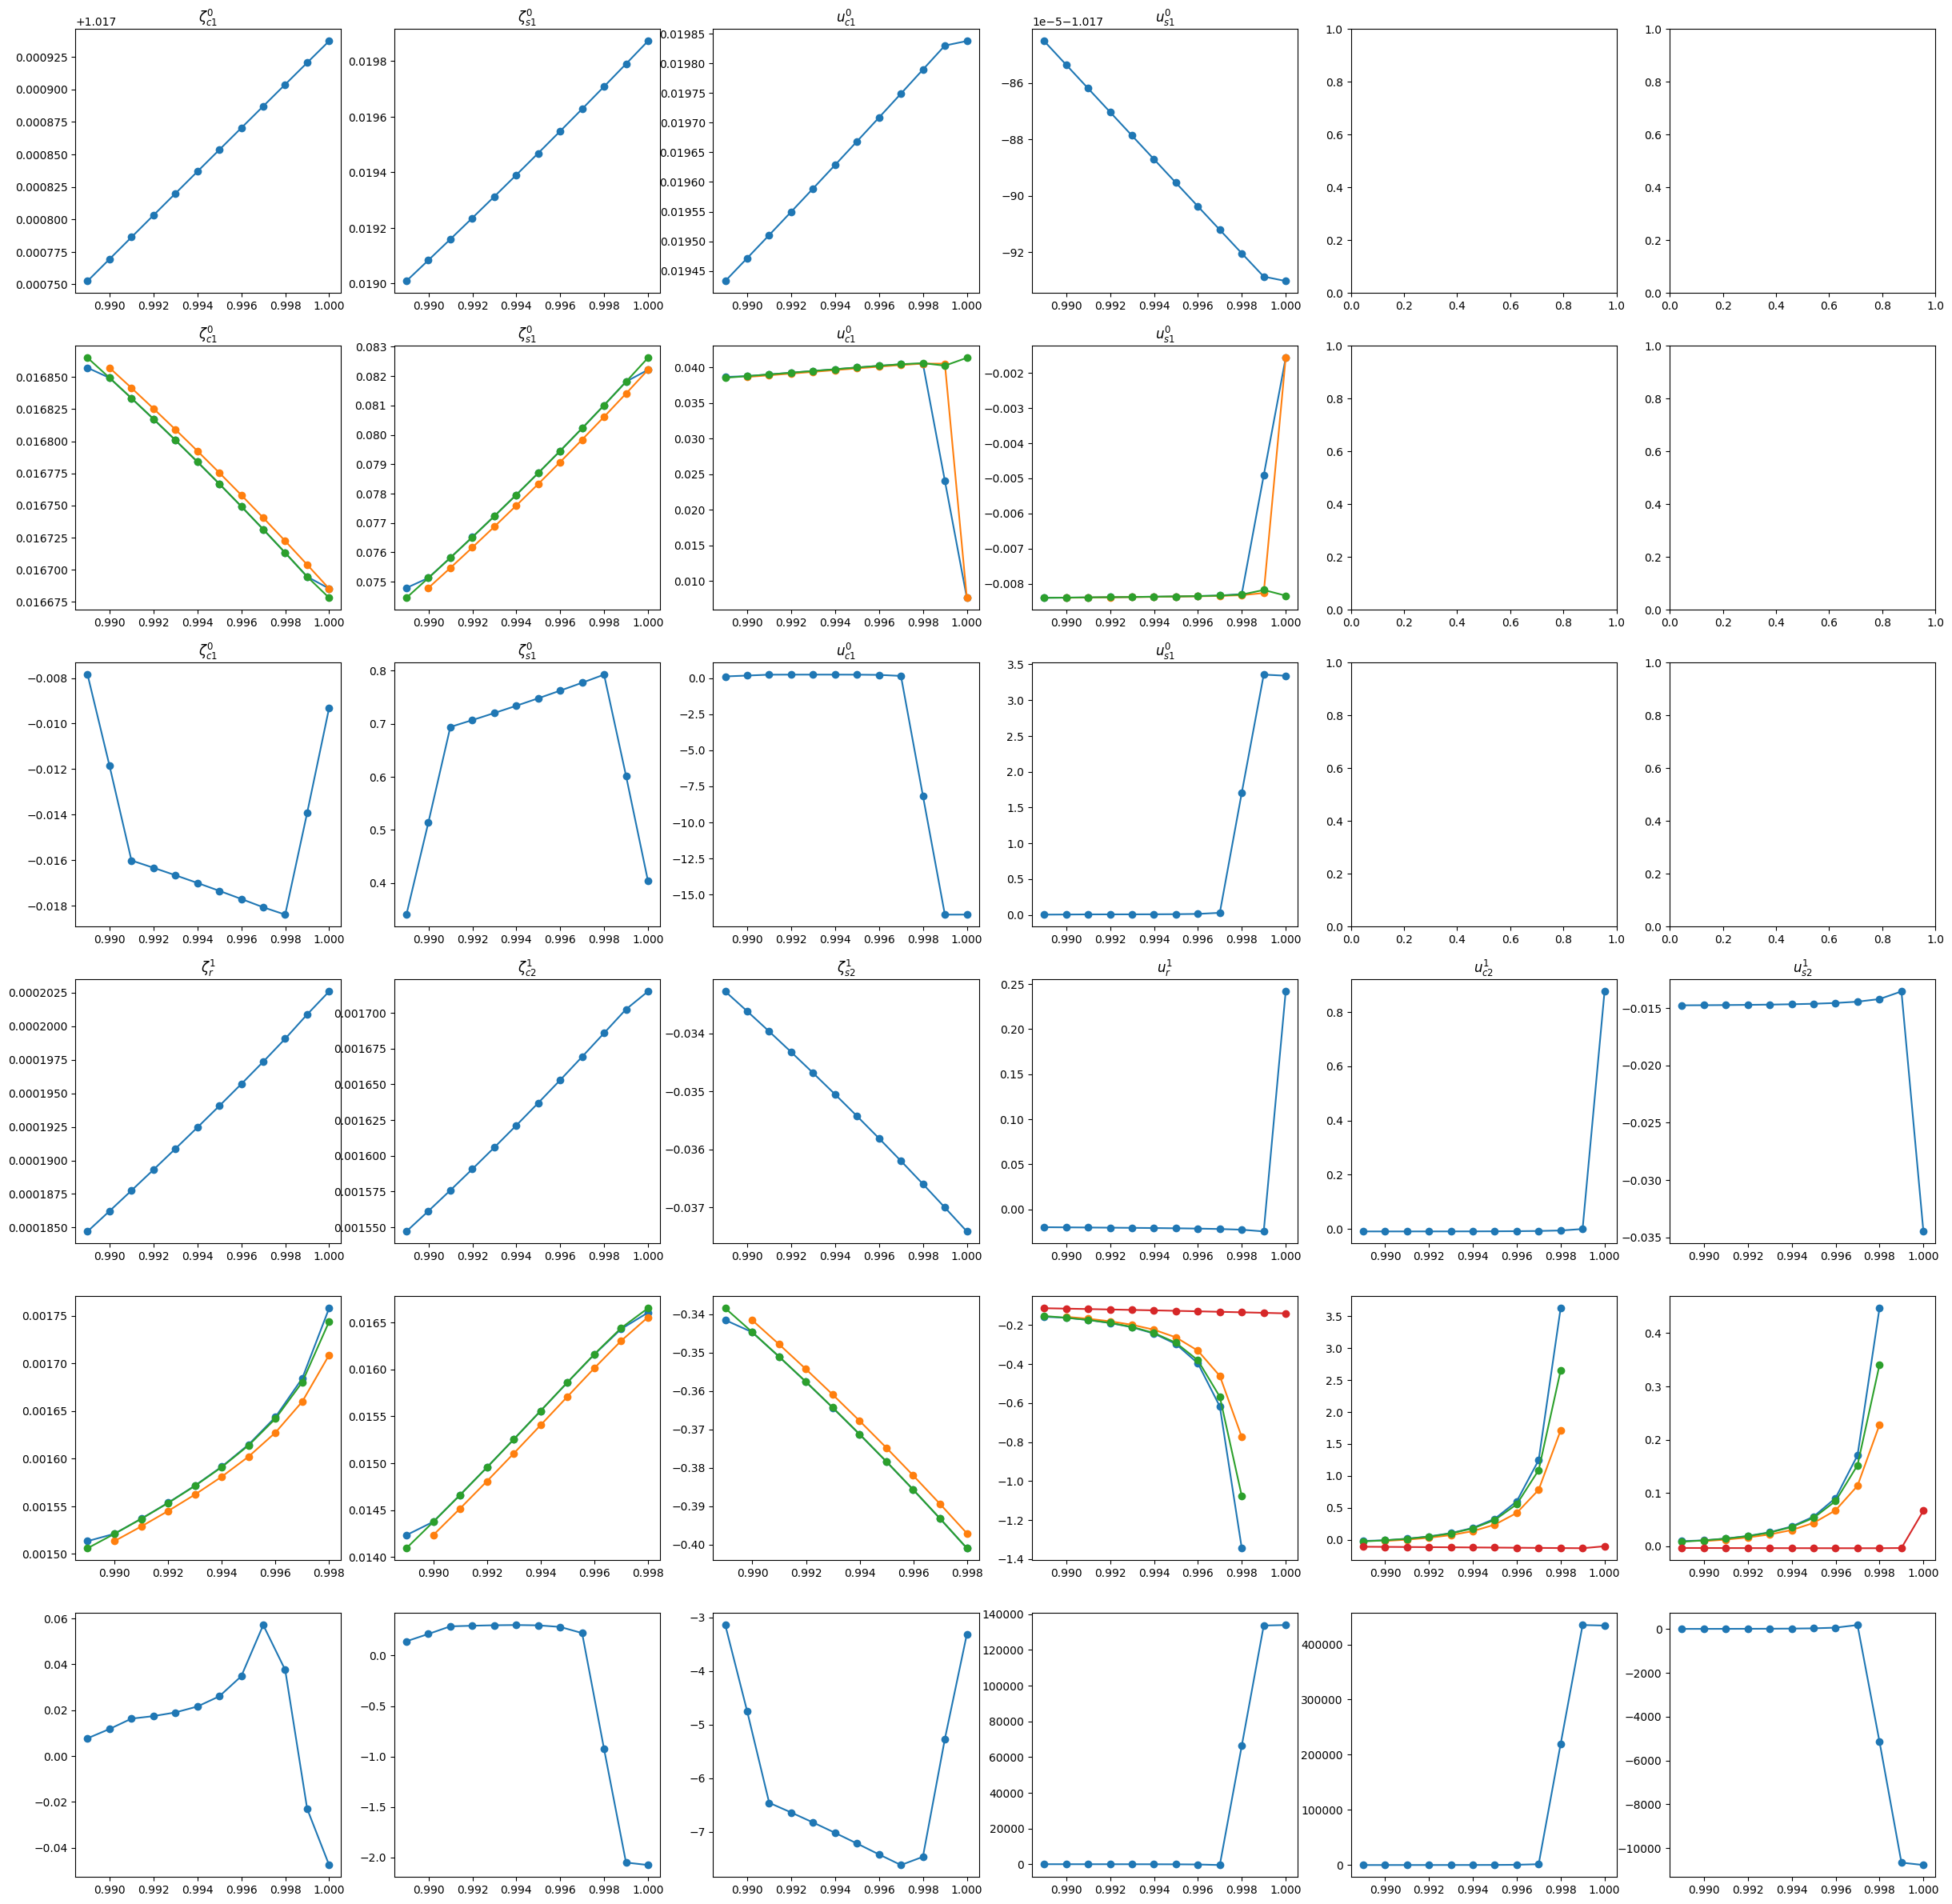

In [ ]:
pcswe = PCSWE()
pcswe.h0 = 0.1
pcswe.r = 0.45
pcswe.small_number = 0
pcswe.tol = 1e-5
pcswe.set_derivative_vars()
res, sol = pcswe.solve_shooting()
x = linspace(0, 1, 1000)


fig, axs = plt.subplots(6, 6, figsize=(30, 30))
labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]


st = -50
x = x[st:]
y_x_dx = np.array([pcswe.deriv(x_, sol.sol(x_)) for x_ in x]).T
u1_x_dx = np.array([pcswe.lhopital_FO(x_, y_[4:], y_[:4], y_dx[:4], y_dx[4:7]) for x_, y_, y_dx in zip(x, sol.sol(x).T, y_x_dx.T)]).T


for i in range(4):
    axs[0, i].set_title(labels[i])
    axs[0, i].plot(x, sol.sol(x)[i],'o-')
for i in range(4):
    axs[1, i].set_title(labels[i])
    axs[1, i].plot(x, np.gradient(sol.sol(x)[i], x),'o-')
    axs[1, i].plot(x[1:], np.diff(sol.sol(x)[i]) / np.diff(x),'o-')
    axs[1, i].plot(x, y_x_dx[i], 'o-')
for i in range(4):
    axs[2, i].set_title(labels[i])
    axs[2, i].plot(x, np.gradient(np.gradient(sol.sol(x)[i], x), x),'o-')
for i in range(6):
    axs[3, i].set_title(labels[4+i])
    axs[3, i].plot(x, sol.sol(x)[4+i],'o-')
for i in range(6):
    axs[4, i].plot(x[:-2], np.gradient(sol.sol(x)[4+i], x)[:-2],'o-')
    axs[4, i].plot(x[1:-2], (np.diff(sol.sol(x)[4+i]) / np.diff(x))[:-2],'o-')
    axs[4, i].plot(x[:-2], y_x_dx[4+i][:-2], 'o-')
for i in range(3):
    axs[4, 3+i].plot(x, u1_x_dx[i], 'o-')

for i in range(6):
    axs[5, i].plot(x, np.gradient(np.gradient(sol.sol(x)[4+i], x), x),'o-')
plt.show()


[9.99999999999890e-05 1.46536491590576e-04 1.90639366131395e-04
 2.57333918986857e-04 3.54912169501231e-04 5.02037345041284e-04
 7.29185163633073e-04 1.08885968445938e-03 1.67382576785702e-03
 2.65364573759108e-03 4.34993403590522e-03 7.40060234702755e-03
 1.31456054796874e-02 2.45868636846881e-02 4.74052809859495e-02
 9.00550124538056e-02 1.60988897845297e-01 2.60922433786671e-01
 4.09537034993332e-01 6.36242127354950e-01 9.90787611439994e-01
 1.00000000000000e+00]
9.999999999998899e-05
(10, 10)
(10,)
(3, 10)
(10,)


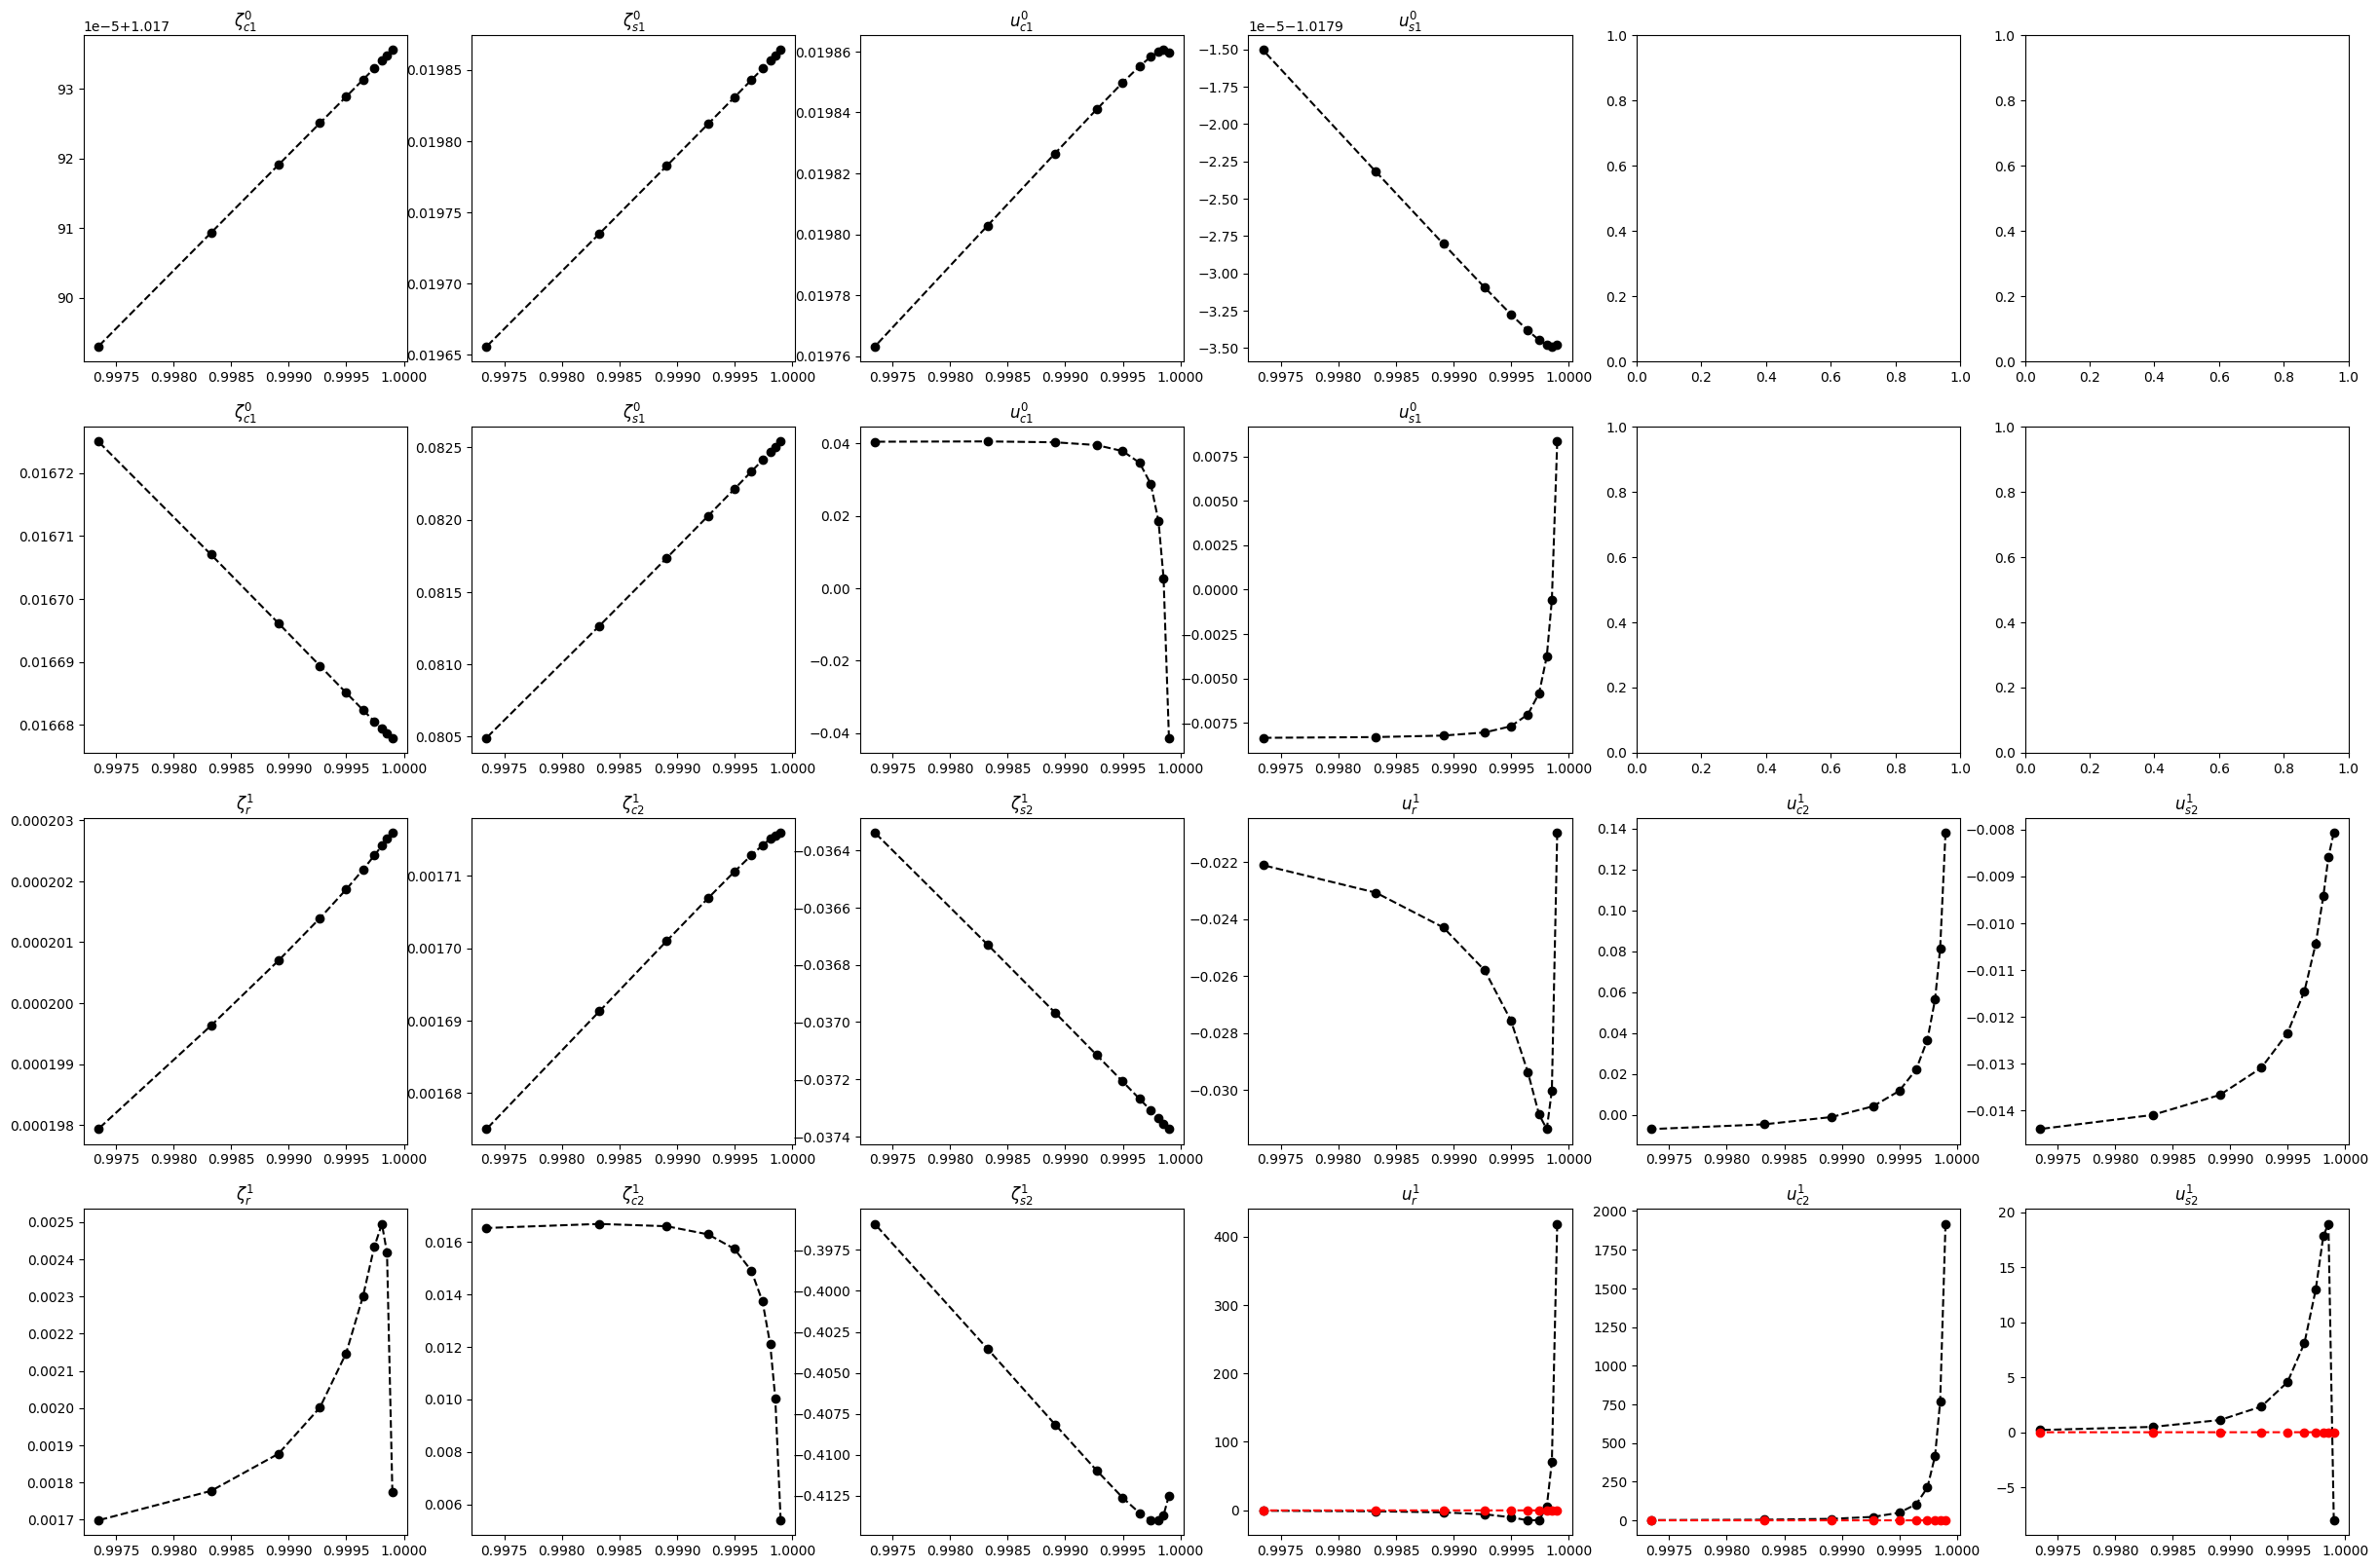

In [5]:

fig, axs = plt.subplots(4, 6, figsize=(30, 20))
labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]


x_sol = sol.t
np.set_printoptions(precision=14)
print(1 - sol.t)
print(1 - sol.t[0])

y_sol = sol.y

threshold = x_sol[10]
y_sol = y_sol[:, x_sol > threshold]
x_sol = x_sol[x_sol > threshold]
# print(y_sol.shape, x_sol.shape)



# x = x[st:]
y_sol_dx = np.array([pcswe.deriv(x_, y_) for x_, y_ in zip(x_sol, y_sol.T)]).T
u1_x_dx = np.array([pcswe.lhopital_FO(x_, y_[4:], y_[:4], y_dx[:4], y_dx[4:7]) for x_, y_, y_dx in zip(x_sol, y_sol.T, y_sol_dx.T)]).T



print(y_sol.shape)
print(x_sol.shape)

for i in range(4):
    axs[0, i].set_title(labels[i])
    axs[0, i].plot(x_sol, y_sol[i],'o--', color='k')
for i in range(4):
    axs[1, i].set_title(labels[i])
    axs[1, i].plot(x_sol, y_sol_dx[i],'o--', color='k')
for i in range(6):
    axs[2, i].set_title(labels[4+i])
    axs[2, i].plot(x_sol, y_sol[4+i],'o--', color='k')
for i in range(6):
    axs[3, i].set_title(labels[4+i])
    axs[3, i].plot(x_sol, y_sol_dx[4+i],'o--', color='k')


print(u1_x_dx.shape)
print(x_sol.shape)
for i in range(3):
    axs[3, 3+i].plot(x_sol, u1_x_dx[i],'o--', color='r')

plt.show()


22
(10, 22) (22,)


IndexError: boolean index did not match indexed array along axis 1; size of axis is 10 but size of corresponding boolean axis is 22

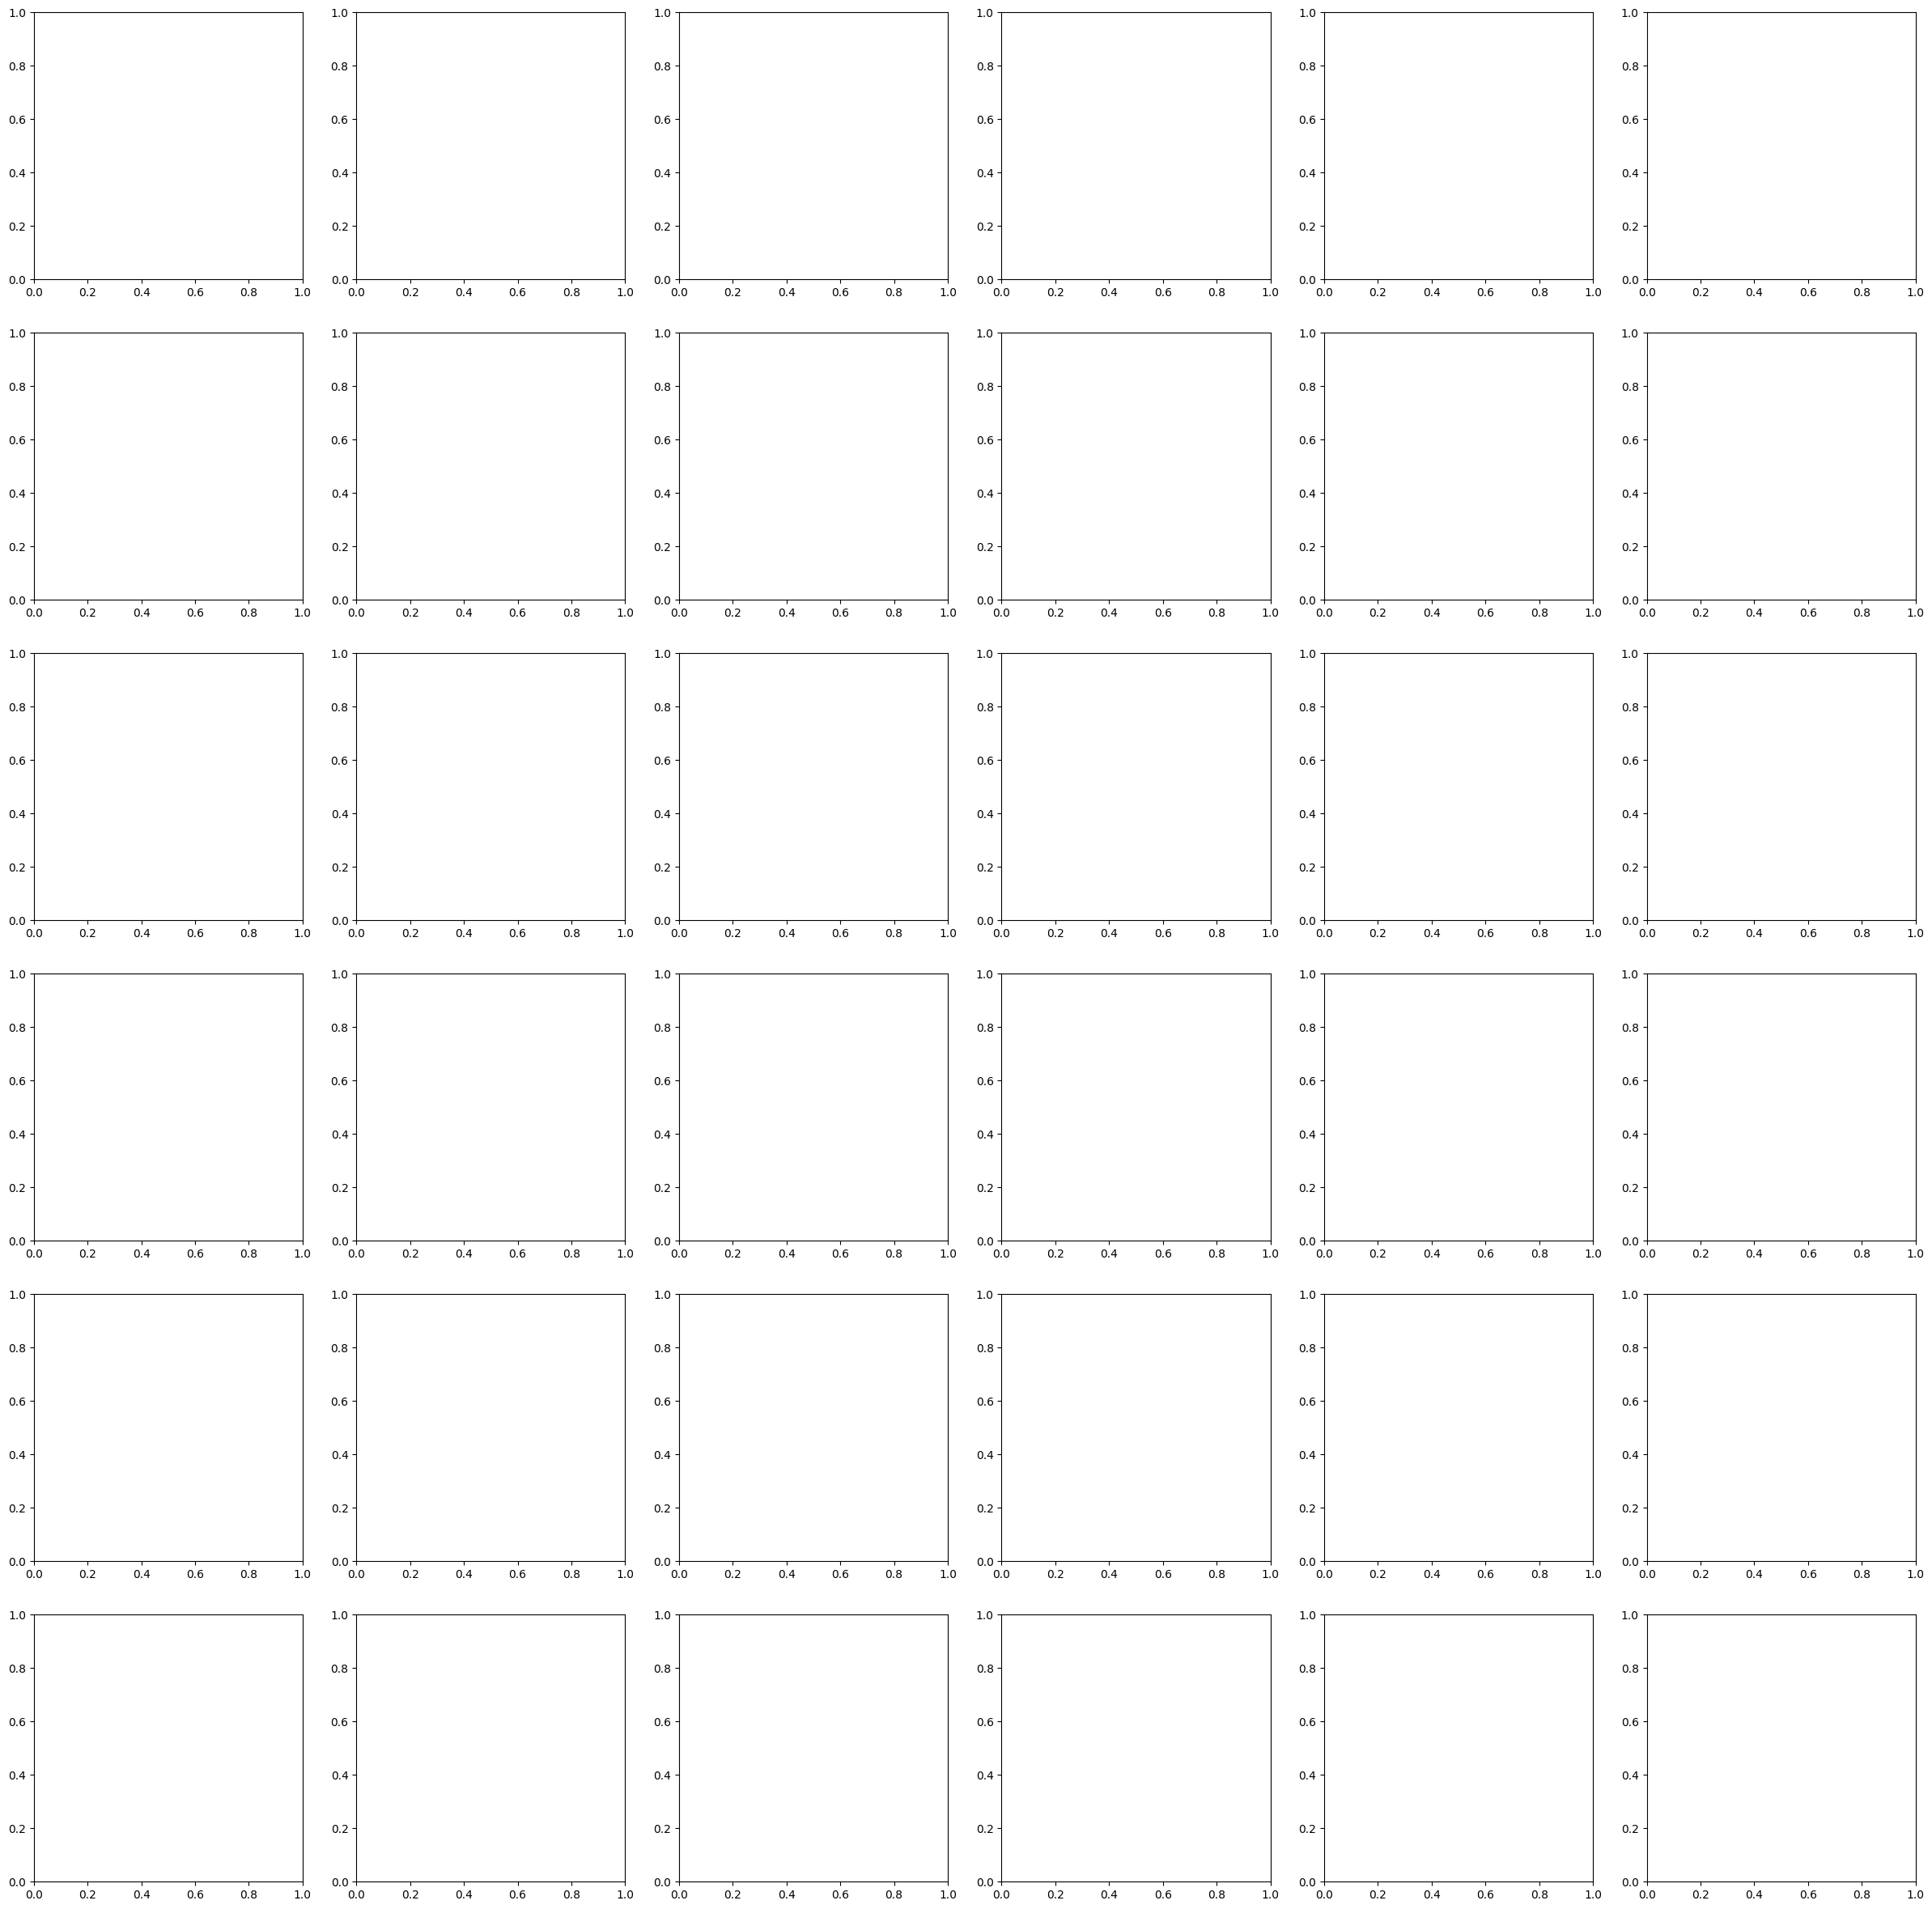

In [6]:



sol = pcswe.ivp_own_initial_step(res.x, dense_output=True)


fig, axs = plt.subplots(6, 6, figsize=(30, 30))
labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]


print(len(sol.t))

# threshold = 1 - 1e-2
threshold = sol.t[10]
# threshold = x[-10]

x = sol.t # or linspace
x = x[x > threshold]


sol_st = 20
x_sol = sol.t[sol.t > threshold]

print(sol.y.shape, sol.t.shape)
y_sol = sol.y.T[:, sol.t > threshold]

# y_x_dx = np.array([pcswe.deriv(x_, sol.sol(x_)) for x_ in x]).T
# u1_x_dx = np.array([pcswe.lhopital_FO(x_, y_[4:], y_[:4], y_dx[:4], y_dx[4:7]) for x_, y_, y_dx in zip(x, sol.sol(x).T, y_x_dx.T)]).T

for i in range(4):
    axs[0, i].set_title(labels[i])
    # axs[0, i].plot(x, sol.sol(x)[i],'o-')
    axs[0, i].plot(x_sol, y_sol[i],'o--', color='k')
for i in range(4):
    axs[1, i].set_title(labels[i])
    # axs[1, i].plot(x, np.gradient(sol.sol(x)[i], x),'o-')
    # axs[1, i].plot(x[1:], np.diff(sol.sol(x)[i]) / np.diff(x),'o-')
    # axs[1, i].plot(x, y_x_dx[i], 'o-')
for i in range(4):
    axs[2, i].set_title(labels[i])
    # axs[2, i].plot(x, np.gradient(np.gradient(sol.sol(x)[i], x), x),'o-')
for i in range(6):
    axs[3, i].set_title(labels[4+i])
    # axs[3, i].plot(x, sol.sol(x)[4+i],'o-')
    axs[3, i].plot(x_sol, y_sol[4+i], 'o--', color='k')
for i in range(6):
    # axs[4, i].plot(x, np.gradient(sol.sol(x)[4+i], x),'o-')
    # axs[4, i].plot(x[1:], np.diff(sol.sol(x)[4+i]) / np.diff(x),'o-')
    # axs[4, i].plot(x, y_x_dx[4+i], 'o-')
    ...

for i in range(3):
    # axs[4, 3+i].plot(x, u1_x_dx[i], 'o-')
    ...

for i in range(6):
    # axs[5, i].plot(x, np.gradient(np.gradient(sol.sol(x)[4+i], x), x),'o-')
    ...
plt.show()
